In [85]:
import numpy as np
import pandas as pd
import xgboost as xgb
import sklearn
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing.imputation import Imputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, roc_auc_score
from sklearn.cross_validation import StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
import os
import random
import matplotlib.pyplot as plt

In [86]:
def makeUserTarget(df, user):
    aux = []
    for _, row in df.iterrows():
        if(np.floor(row.SessionID/100).astype(int) == user):
            aux.append(1)
        else:
            aux.append(0)
    df['target'] = aux

In [87]:
def separateIntoTrainAndTest(df):
    targetSessionIds = list(df[df.target == 1].SessionID.unique())
    targetChoosenSession = random.choice(targetSessionIds)
    notTargetSessionIds = list(df[df.target == 0].SessionID.unique())
    notTargetChoosenSessions = []
    for i in range(10):
        notTargetChoosenSession = random.choice(notTargetSessionIds) 
        notTargetChoosenSessions.append(notTargetChoosenSession)
        notTargetSessionIds.remove(notTargetChoosenSession)
    df_train = df[(df.SessionID != targetChoosenSession) & (~df.SessionID.isin(notTargetChoosenSessions))]
    df_test = df[(df.SessionID == targetChoosenSession) | (df.SessionID.isin(notTargetChoosenSessions))]
    
    return df_train, df_test

In [88]:
file_name = 'five_seconds_features/aggregated_features'
to_drop = []
df = pd.read_csv('./' + file_name + '.csv')

In [89]:
user = 220962
makeUserTarget(df, user)

In [90]:
clf = xgb.XGBClassifier(n_estimators=90, max_depth=4, random_state=31, colsample_bytree=0.5, colsample_bylevel=0.5, learning_rate=0.09, subsample=0.9)

In [91]:
df_train, df_test = separateIntoTrainAndTest(df)

In [92]:
df_train = df_train.set_index(["SessionID", 'WindowNumber']).drop(to_drop, axis=1)
df_test = df_test.set_index(["SessionID", 'WindowNumber']).drop(to_drop, axis=1)

In [93]:
x_train, y_train = df_train.drop("target", axis=1), df_train["target"]

In [94]:
clf.fit(x_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=0.5,
       colsample_bytree=0.5, gamma=0, learning_rate=0.09, max_delta_step=0,
       max_depth=4, min_child_weight=1, missing=None, n_estimators=90,
       n_jobs=1, nthread=None, objective='binary:logistic',
       random_state=31, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=0.9)

In [95]:
i_pred_proba = clf.predict_proba(x_train)

In [96]:
auc = roc_auc_score(y_train, i_pred_proba[:, 1])
print(auc)

0.9999617979089932


In [97]:
x_test, y_test = df_test.drop("target", axis=1), df_test["target"]

In [98]:
predict = clf.predict_proba(x_test)

In [99]:
df_predict = pd.DataFrame(clf.predict_proba(x_test)[:, 1], columns=["prob"], index=x_test.index)

In [100]:
df_socorro = df_predict.merge(df_test[['target']], right_index=True, left_index=True)

In [103]:
df_socorro[df_socorro.target == 0].mean()

prob      0.001966
target    0.000000
dtype: float64

<Figure size 432x288 with 0 Axes>

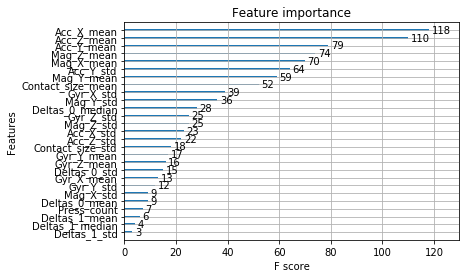

<Figure size 432x288 with 0 Axes>

In [102]:
xgb.plot_importance(clf)
plt.figure()